In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
import xgboost



In [2]:
#read data
data_set = pd.read_csv('class_csv.csv')
y = pd.DataFrame(data_set.iloc[:, 32])
X=  pd.DataFrame(data_set.iloc[:, 2:32])
print(X.head(10))
print(y.head(10))


   followers_count  follow_count  blog_count  indiv_attitude  indiv_comments  \
0              0.0           0.0        11.0        0.000000        0.090909   
1              0.0           0.0         6.0        0.000000        0.000000   
2             18.0          18.0       388.0        0.000000        0.000000   
3              2.0           2.0        57.0        0.000000        0.000000   
4            195.0         195.0       557.0        0.000000        0.000000   
5            101.0         101.0        39.0        0.000000        0.000000   
6              1.0           1.0        27.0        0.000000        0.000000   
7             34.0          34.0        11.0        0.181818        0.000000   
8            101.0         101.0       588.0        0.125000        0.062500   
9             23.0          23.0       962.0        0.000000        0.000000   

   indiv_reposts  indiv_latenight  indiv_neg_emoji   Cogproc    Negemo  ...  \
0            0.0         0.000000       

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)
print("done")

done


In [85]:
classifiers = {}


classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Xgboost": xgboost.XGBClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})


DECISION_FUNCTIONS = { "LSVC", "NuSVC", "SVC"}


FEATURE_IMPORTANCE = {"Random Forest"}
print("done")


done


In [86]:
#hyper pramaters
parameters = {}

parameters.update({"Random Forest": {
                                    "classifier__n_estimators": [100],
                                    "classifier__class_weight": ["balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [9],
                                    "classifier__min_samples_split": [0.01],
                                    "classifier__min_samples_leaf": [0.005],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})




parameters.update({"AdaBoost": {
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.05, 0.1,0.15]
                                 }})


parameters.update({"Xgboost": {
                            'classifier__learning_rate':[0.01,0.05,0.1],
                            'classifier__n_estimators': [25,50,75] ,
                            'classifier__max_depth': [2,3,4] ,
                            'classifier__min_child_weight': [1,2,3,5] ,
                            'classifier__seed': [0],
                            'classifier__objective':['binary:logistic'],
                            'classifier__reg_alpha': [0,0.3], 
                            'classifier__reg_lambda': [0.3,0.5]
                                 }})



parameters.update({"SVC": {
    "classifier__kernel": ["linear", "rbf", "poly"],
    "classifier__gamma": ["auto"],
    "classifier__C": [0.25, 0.5, 0.75, 1],
    "classifier__degree": [ 2, 3, 4]
}})

# Update dict with Decision Tree Classifier
parameters.update({"DTC": {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__splitter": ["best", "random"],
    "classifier__class_weight": [None, "balanced"],
    "classifier__max_features": ["auto", "sqrt", "log2"],
    "classifier__max_depth": [1,2,3, 4, 5, 6, 7],
    "classifier__min_samples_split": [0.001,0.005, 0.01, 0.05, 0.10],
    "classifier__min_samples_leaf": [0.001,0.005, 0.01, 0.05, 0.10],
}})

Hyper Parameters saved


drop: ['follow_count']
done


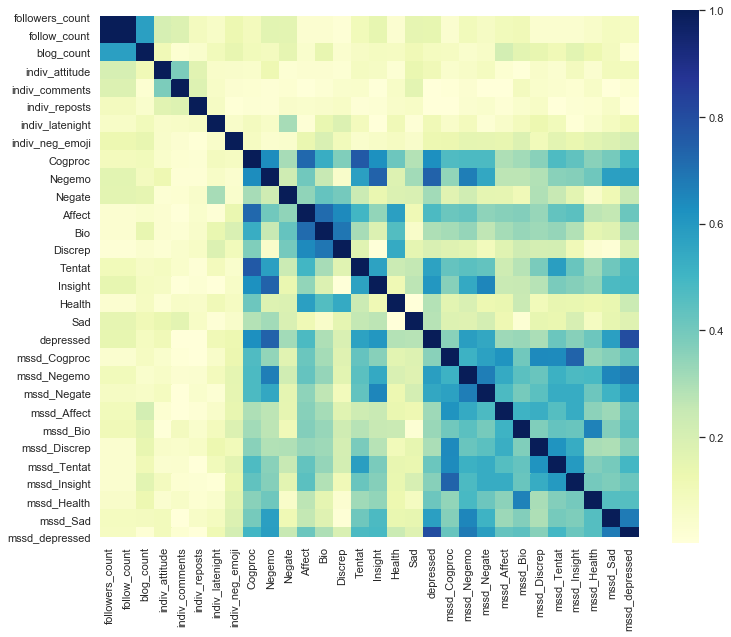

In [6]:

corr_matrix = X_train.corr(method="spearman").abs()


sns.set(font_scale=1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap="YlGnBu", square=True, ax=ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi=1080)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

print("drop:",to_drop)
print("done")

In [7]:
FEATURE_IMPORTANFCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}
print("done")

done


In [11]:
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

scaler = StandardScaler()

steps = [("scaler", scaler), ("classifier", classifier)]
pipeline = Pipeline(steps=steps)
param_grid = parameters[selected_classifier]
gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")


print(f" tuning {selected_classifier}. ")
gscv.fit(X_train, np.ravel(y_train))


best_params = gscv.best_params_
best_score = gscv.best_score_

print(best_params)
print(best_score)
tuned_params = {item[12:]: best_params[item] for item in best_params}
print((tuned_params))
classifier.set_params(**tuned_params)

 tuning Random Forest. 
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 0.005, 'classifier__min_samples_split': 0.005, 'classifier__n_estimators': 100, 'classifier__n_jobs': -1}
0.8765192667410094
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 100, 'n_jobs': -1}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 16.6min finished
c:\users\surface\pycharmprojects\pycharm_packages\venv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.005,
                       min_samples_split=0.005, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [12]:
# Select Features using RFECV
class PipelineRFE(Pipeline):
    #  https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self



# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps=steps)

# Initialize RFECV
feature_selector = RFECV(pipe, cv=5, step=1, scoring="f1_macro", verbose=1)
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()
print("N_features %s" % feature_selector.n_features_)
print("Support is %s" % feature_selector.support_)
print("Ranking %s" % feature_selector.ranking_)
print("Grid Scores %s" % feature_selector.grid_scores_)
print(selected_features)

Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [90]:

performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                     "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)


sns.set(font_scale=1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]


f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x="Number of Features", y="AUC", data=performance_curve,
             color=line_color, lw=4, ax=ax)
sns.regplot(x=performance_curve["Number of Features"], y=performance_curve["AUC"],
            color=marker_colors, fit_reg=False, scatter_kws={"s": 200}, ax=ax)

plt.xlim(0.5, len(feature_names) + 0.5)
plt.ylim(0.60, 1.0)

ax.axhline(y=0.625, color='black', linewidth=1.3, alpha=.7)

ax.set_frame_on(False)
plt.tight_layout()
plt.savefig("performance_curve.png", dpi=1080)


AttributeError: 'RFE' object has no attribute 'grid_scores_'

In [18]:

steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps=steps)
feature_selector = RFE(pipe, n_features_to_select=9, step=1, verbose=1)
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()
print(selected_features)

Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
['blog_count', 'Cogproc', 'Negemo', 'Negate', 'Tentat', 'Insight', 'Sad', 'depressed', 'mssd_depressed']


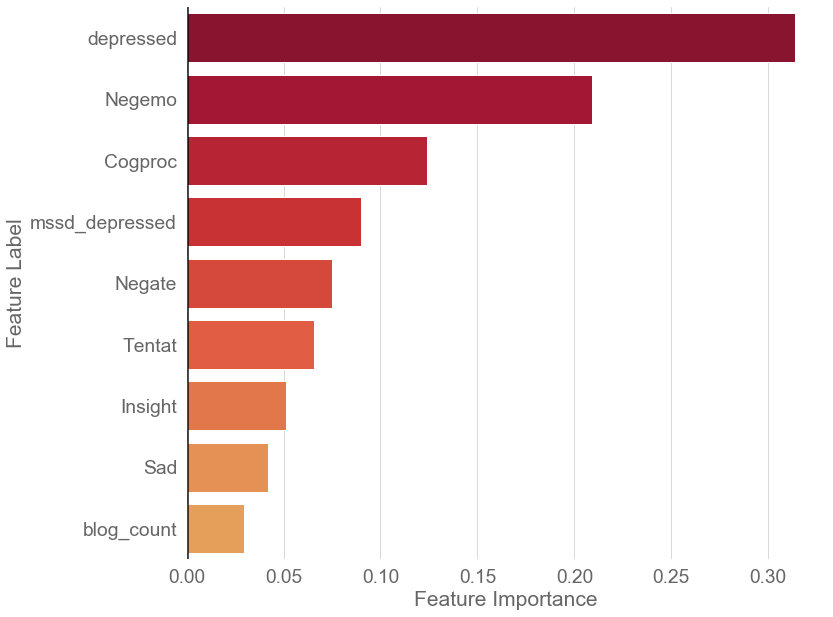

In [78]:

X_train = X_train[selected_features]
X_test = X_test[selected_features]


classifier.fit(X_train, np.ravel(y_train))


feature_importance = pd.DataFrame(selected_features, columns=["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)


sns.set(font_scale=1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x="Feature Importance", y="Feature Label",
            palette=reversed(sns.color_palette('YlOrRd', 15)), data=feature_importance)

ax.axvline(x=0, color='black', linewidth=4, alpha=.7)


ax.set_frame_on(False)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=1080)

In [87]:

results = {}


for classifier_label, classifier in classifiers.items():
    print(f"Now tuning {classifier_label}.")
    scaler = StandardScaler()

    steps = [("scaler", scaler), ("classifier", classifier)]
    pipeline = Pipeline(steps=steps)
    param_grid = parameters[classifier_label]
    gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

    gscv.fit(X_train, np.ravel(y_train))

    #best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    print(best_score)
    print(best_params)
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)

    # predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
        y_pred_class=gscv.predict(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:, 1]
        y_pred_class=gscv.predict(X_test)
        
    
    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)
    model_status=metrics.classification_report(y_test, y_pred_class)
    print(model_status)

    # Save results
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc,
              "model_status":model_status}

    results.update({classifier_label: result})

Now tuning AdaBoost.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8363149792322251
{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       223
           1       0.85      0.69      0.76        42

    accuracy                           0.93       265
   macro avg       0.90      0.83      0.86       265
weighted avg       0.93      0.93      0.93       265

Now tuning Xgboost.
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
0.8419836888443508
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 75, 'classifier__objective': 'binary:logistic', 'classifier__reg_alpha': 0.3, 'classifier__reg_lambda': 0.5, 'classifier__seed': 0}
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       223
           1       0.86      0.76  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 996 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.1min finished
c:\users\surface\pycharmprojects\pycharm_packages\venv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | el

AdaBoost
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       223
           1       0.85      0.69      0.76        42

    accuracy                           0.93       265
   macro avg       0.90      0.83      0.86       265
weighted avg       0.93      0.93      0.93       265

Xgboost
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       223
           1       0.86      0.76      0.81        42

    accuracy                           0.94       265
   macro avg       0.91      0.87      0.89       265
weighted avg       0.94      0.94      0.94       265

Random Forest
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       223
           1       0.81      0.90      0.85        42

    accuracy                           0.95       265
   macro avg       0.90      0.93      0.91       265
weighted avg       0.95      0.95      0.95

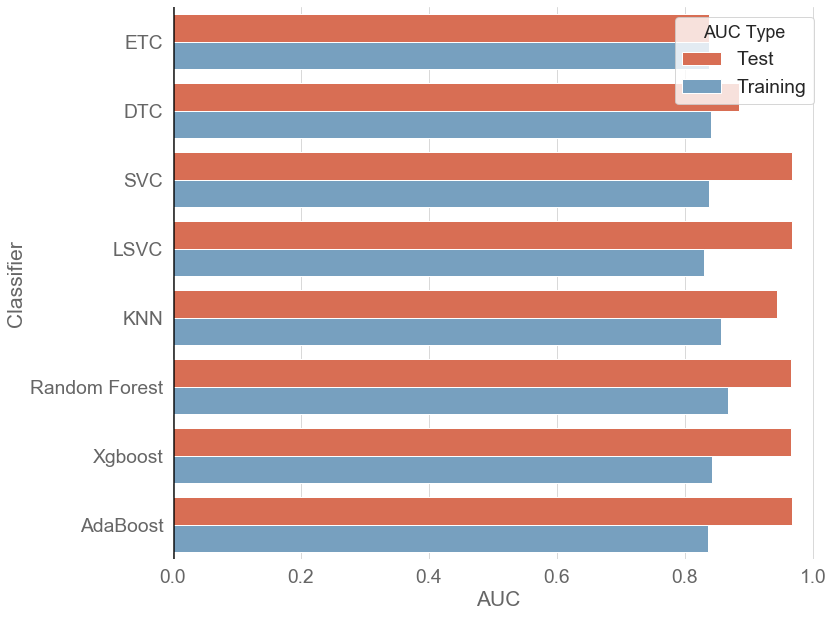

In [88]:

auc_scores = {
    "Classifier": [],
    "AUC": [],
    "AUC Type": []
}

model_state={}
status_txt=open("model_status.txt","w",encoding='UTF-8')
for classifier_label in results:
    print(classifier_label)
    status_txt.write(classifier_label)
    status_txt.write('\n')
    print(results[classifier_label]["model_status"])
    status_txt.write(results[classifier_label]["model_status"])
    status_txt.write('\n')
status_txt.close()
    

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Training AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Training"] + auc_scores["AUC Type"]})

    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Test AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Test"] + auc_scores["AUC Type"]})

auc_scores = pd.DataFrame(auc_scores)
print(auc_scores)
auc_scores.to_csv("C:/Users/surface/Desktop/final project/codes/the whole process/classifier/score.csv")


sns.set(font_scale=1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# barplot
f, ax = plt.subplots(figsize=(12, 9))

sns.barplot(x="AUC", y="Classifier", hue="AUC Type", palette=colors,
            data=auc_scores)

# Generate a bolded horizontal line at y = 0
ax.axvline(x=0, color='black', linewidth=4, alpha=.7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
#.savefig("AUC Scores.png", dpi=1080)

